### Utilities & Benchmarking for video reading operations 

> Referefences:
> - https://www.kaggle.com/mpware/videoreaders-benchmark

The way frames are selected is also a way to speed up frames retrieval. One can get either regular spaced interval frames or frames spaced with stride interval. For instance if you want 3 frames for a video with 300 frames:

With regular interval you would get [0, 100, 200].
With stride=3 you would get [0, 3, 6] which is faster to load as reader stops quickly after frame 6.

In [51]:
# default_exp core.video_core

In [52]:
#export
from fastai.vision import *
import cv2

In [53]:
# hide
# video files for testing
video_files = get_files("/home/ubuntu/data/dfdc/dfdc_train_part_49/", extensions=['.mp4'])
sample_video_fname = video_files[0]

### vanilla `opencv` 

In [55]:
# export
def open_cv_video_reader(path, freq=None):
    "optionally sample by freq and yield RGB image frames from a video"
    vidcap = cv2.VideoCapture(str(path))
    video_len = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
    for i in range(video_len):
        vidcap.grab()
        if (freq is None) or (i % freq == 0):
            _, image = vidcap.retrieve()
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            yield {"frame_no":i, "frame_array":image}

In [56]:
%%timeit
#hide
frames = list(open_cv_video_reader(sample_video_fname, 10))

386 ms ± 4.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### `Decord (CPU)`

In [57]:
#export
from decord import VideoReader
from decord import cpu
from decord.bridge import set_bridge
set_bridge('torch')

In [99]:
#export
def decord_cpu_video_reader(path, freq=None):
    video = VideoReader(str(path), ctx=cpu())
    len_video = len(video)
    if freq: t = video.get_batch(range(0, len(video), freq))
    else: t = video.get_batch(range(len_video))
    return t, len_video

Compare Decord CPU and OpenCV frame batching speeds. Decord is a bit better when pytorch tensors are preffered.

In [100]:
%%timeit
#hide
t1, _ = decord_cpu_video_reader(sample_video_fname, 10)

392 ms ± 5.19 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [101]:
%%timeit
#hide
t2 = (torch.from_numpy(array([o['frame_array'] for o in open_cv_video_reader(sample_video_fname, 10)]))
           .permute(0,3,1,2))

415 ms ± 2.47 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [102]:
t1, _ = decord_cpu_video_reader(sample_video_fname, 10)
t2 = (torch.from_numpy(array([o['frame_array'] for o in open_cv_video_reader(sample_video_fname, 10)]))
           .permute(0,3,1,2)).contiguous()

In [103]:
assert t1.shape == t2.shape

In [104]:
print(torch.equal(t1, t2))
print(f"pixel diffs in frames: {(t1 != t2).contiguous().view(t1.size(0), -1).sum(-1)})")

False
pixel diffs in frames: tensor([      0,       0,       0,       0,       0,       0,       0,       0,
              0,       0,       0,       0,       0,       0,       0,       0,
              0,       0,       0,       0,       0,       0,       0,       0,
              0,       0,       0,       0,       0,       0, 1785463]))


### Decord Video Batch

Additional resizing, normalizing etc..

In [109]:
#export
def get_decord_video_batch_cpu(path, freq=10, sz=640, stats:Tensor=None, device=defaults.device):
    "get resized and mean substracted batch tensor of a sampled video (scale of 255)"
    t_raw, len_video = decord_cpu_video_reader(path, freq)
    H,W = t_raw.size(2), t_raw.size(3) 
    t = F.interpolate(t_raw.to(device).to(torch.float32), (sz,sz))
    if stats is not None: t -= stats[...,None,None]
    return t, t_raw, (H, W), len_video

In [110]:
%%timeit
t, t_raw, (H,W), len_video = get_decord_video_batch_cpu(sample_video_fname, 10)

446 ms ± 11.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [111]:
t.shape, t_raw.shape

(torch.Size([31, 3, 640, 640]), torch.Size([31, 3, 1280, 720]))

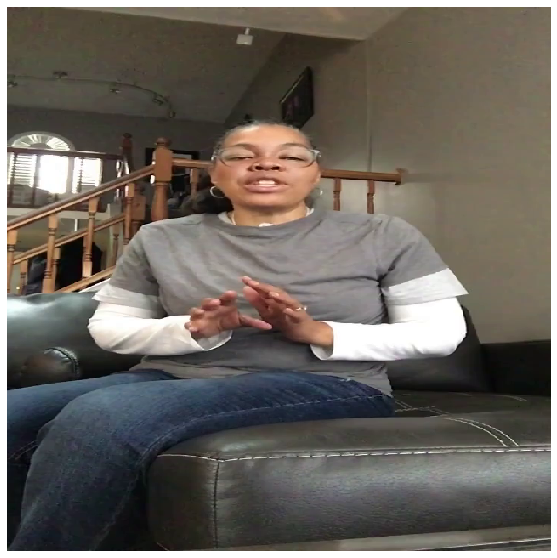

In [112]:
Image(t[0].byte()).show(figsize=(10,10))

### Play a video in Jupyter Notebook

In [84]:
#export
from IPython.display import HTML
from base64 import b64encode

def video_url(fname):
    vid1 = open(fname,'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(vid1).decode()
    return data_url

def play_video(fname1, fname2=None): 
    url1 = video_url(fname1)
    url2 = video_url(fname2) if fname2 else None
    if url1 and url2:
        html = HTML(
            """
        <video width=450 controls>
              <source src="%s" type="video/mp4">
        </video>
        <video width=450 controls>
              <source src="%s" type="video/mp4">
        </video>

        """ % (url1, url2))
    else:
        html = HTML(
            """
        <video width=450 controls>
              <source src="%s" type="video/mp4">
        </video>
        """ % (url1))
    return html

In [85]:
from dfdc.core.core import read_metadata
metadata = get_files("/home/ubuntu/data/dfdc/dfdc_train_part_49/", extensions=['.json'])
metadf = read_metadata(metadata[0])
original_fname = metadf[metadf.fname == sample_video_fname.name]['original'].values[0]
original_video_fname = sample_video_fname.parent/original_fname

In [86]:
play_video(sample_video_fname, original_video_fname)

### export

In [115]:
from nbdev.export import notebook2script

In [116]:
notebook2script()

Converted 001 - extract_faces.ipynb.
Converted 002 - face_detection_retinaface.ipynb.
Converted 003 - save_face_crops.ipynb.
Converted 004 - tl_baseline.ipynb.
Converted 00_core.ipynb.
Converted 01_video_core.ipynb.
Converted 10_bbox_utils.ipynb.
Converted 11_retinaface_detection.ipynb.
Converted index.ipynb.
